In [2]:
import sys
import os
from one.api import ONE

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from utils.load_meso_session import MesoscopeSession


# Load the session data
one = ONE()
SESSION_INDEX = 0
# session = MesoscopeSession.from_csv(one, '../good_mesoscope_sessions_final.csv', SESSION_INDEX, True)
# Using a 1000s window as in your example. You can remove the time_window argument to use the full session.
# activity_matrix, timestamps = session.get_activity_matrix()

activity_matrix, timestamps, eid = MesoscopeSession.load_session_from_hdf5('../DATA/activity_raw.h5')
print(f"Successfully loaded data. Activity matrix shape: {activity_matrix.shape}")

Activity matrix loaded from ../DATA/activity_raw.h5
Shape: (19081, 7673) (time_points x neurons)
Metadata: {'date': '2025-04-09T12:10:56.318000', 'duration_hours': np.float64(1.0843897222222223), 'eid': '61f260e7-b5d3-4865-a577-bcfc53fda8a8', 'n_total_neurons': np.int64(7673), 'shape_description': 'activity_matrix: [time_points, neurons], timestamps: [time_points]', 'subject': 'SP066', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld8.27.6/_sp_passiveVideo8.27.6', 'time_window': 'full_session'}
Successfully loaded data. Activity matrix shape: (19081, 7673)


NEURAL CROSS-PREDICTION WITH PYTORCH FORECASTING DEEPVAR

1. Preparing neural data...
Converting neural data to PyTorch Forecasting format...
Original shape: (19081, 7673)
Original data range: [-532.0, 28183.4]
Selected 1010 most active neurons
Selected data range: [-532.0, 28183.4]
After min-max: [0.000, 1.000]
Created dataset with 19271810 rows
Time steps: 19081
Neurons: 1010
Final value range: [0.000, 1.000]

2. Creating time series datasets...
Creating TimeSeriesDataSet...
Encoder length: 20, Prediction length: 1
Training samples: 19250600
Validation samples: 1010

3. Training DeepVAR model...
Training DeepVAR model...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using multivariate distribution with rank: 1
Finding optimal learning rate...


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 2 steps due to diverging loss.
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
Restoring states from the checkpoint path at /cs/student/msc/aibh/2024/gcosta/mpci-transformer/3_MODELLING/.lr_find_e4c5ffdf-4df2-470d-8bd9-ee8200ae6e4f.ckpt
Restored all states from the checkpoint at /cs/student/msc/aibh/2024/gcosta/mpci-transformer/3_MODELLING/.lr_find_e4c5ffdf-4df2-470d-8bd9-ee8200ae6e4f.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                               | Params | Mode 
--------------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0      | train
1 | logging_metrics        | ModuleList                         | 0      | train
2 | embeddings             | MultiEmbedding   

Optimal learning rate: 0.0001
Training model...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



4. Evaluating model...
Evaluating model...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Baseline MAE: 0.0405
DeepVAR MAE: 0.0320
Improvement: 20.9%

5. Plotting predictions...
Generating prediction plots...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



6. Analyzing cross-neuron correlations...
Analyzing learned correlations...


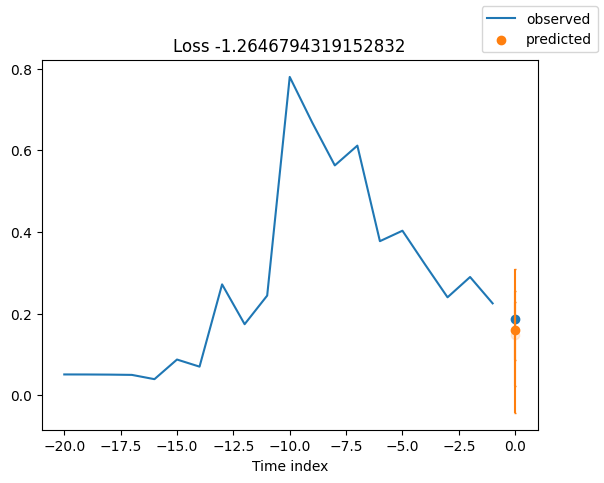

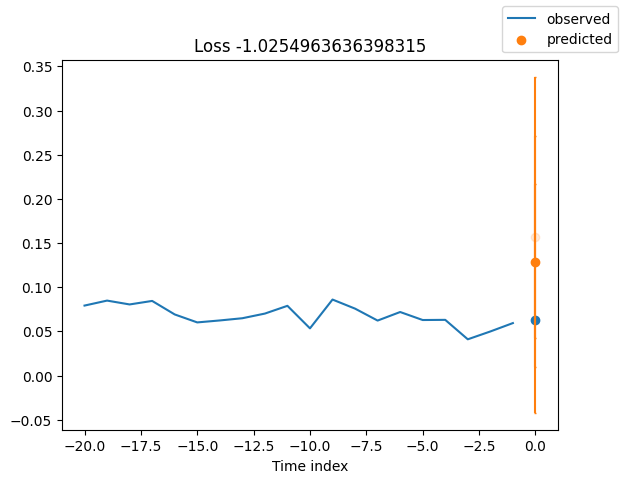

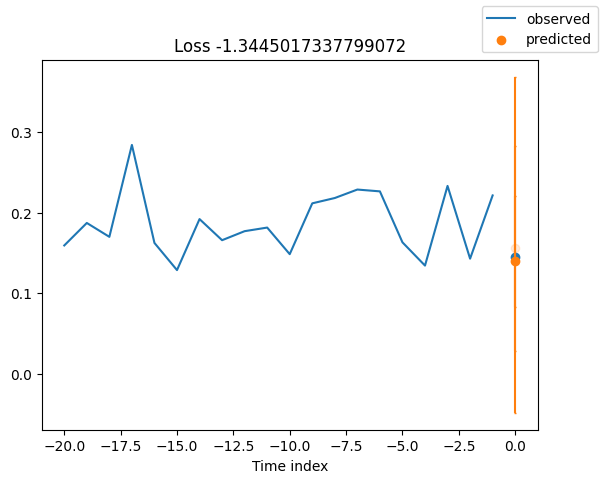

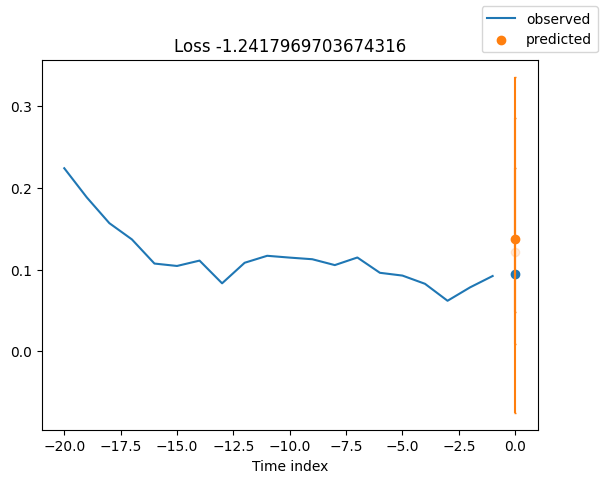

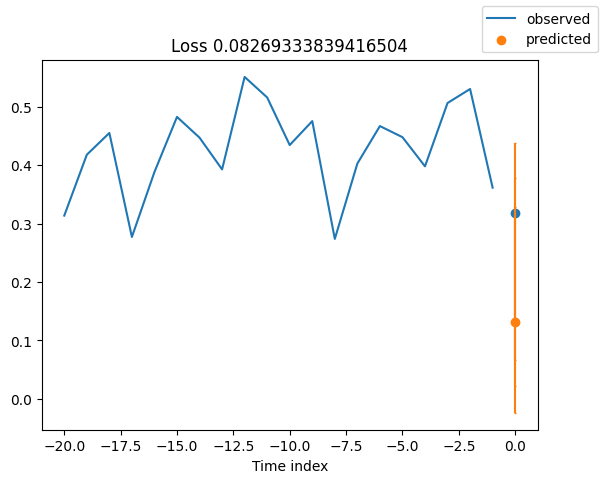

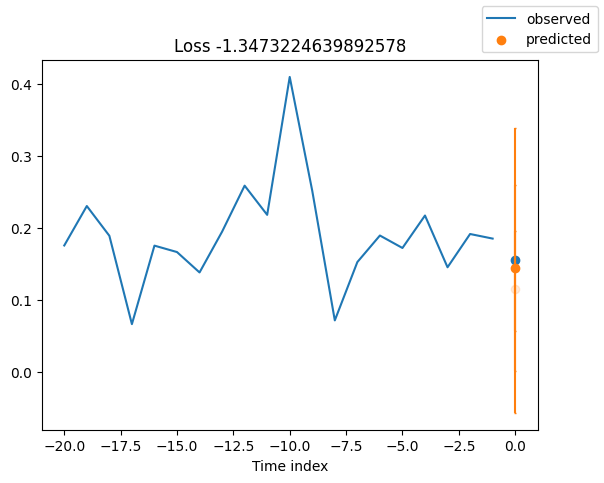

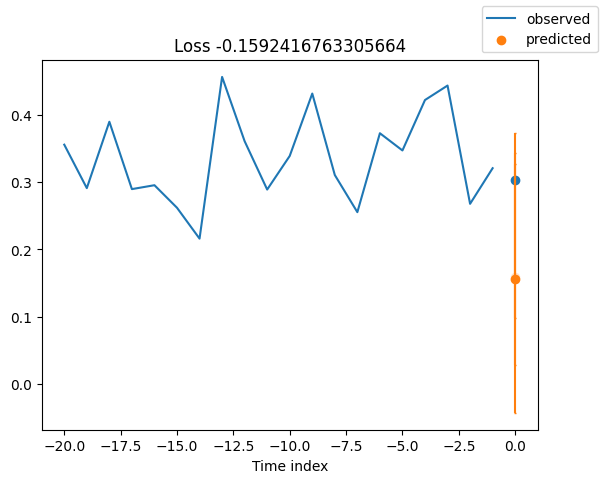

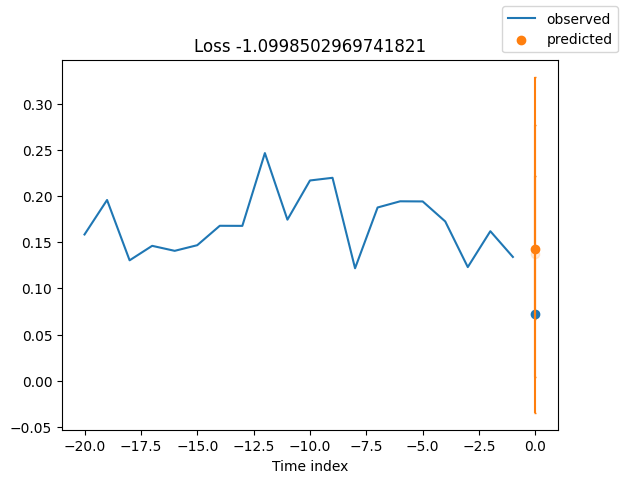

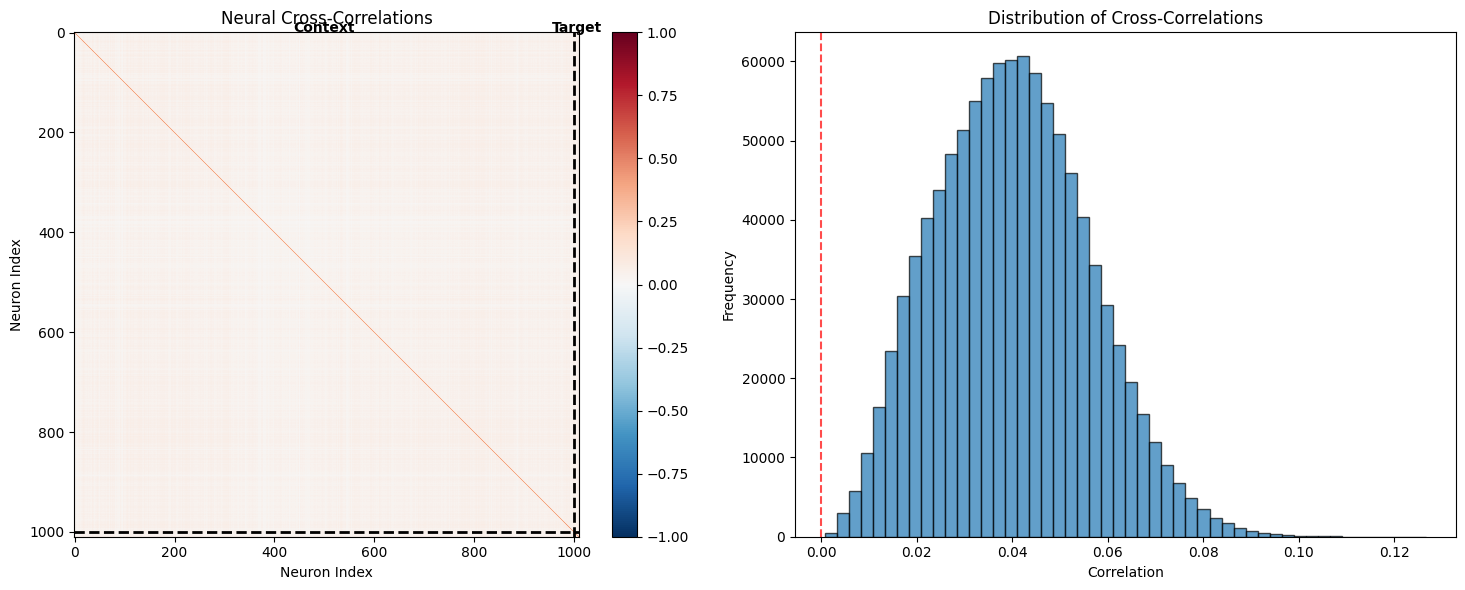

Correlation statistics:
  Mean: 0.040
  Std: 0.016
  Min: 0.001
  Max: 0.127

PIPELINE COMPLETE!
Final Performance - MAE: 0.0320 (vs Baseline: 0.0405)
Improvement: 20.9%
Performance improvement: 20.9%


In [5]:
import warnings
warnings.filterwarnings("ignore")

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import seaborn as sns

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss

def prepare_neural_data_for_pytorch_forecasting(activity_matrix, context_neurons=30, target_neurons=10, normalization='robust'):
    """
    Convert neural activity matrix to PyTorch Forecasting format.
    
    PyTorch Forecasting expects data in long format with:
    - time_idx: time step
    - series: identifier for each neuron 
    - value: the activity value
    - group_ids: grouping variable (we'll use 'neuron_id')
    
    Args:
        activity_matrix: [time, neurons] numpy array
        context_neurons: number of context neurons to include
        target_neurons: number of target neurons to predict
        normalization: 'log', 'robust', 'zscore', or 'minmax'
    
    Returns:
        pandas DataFrame in PyTorch Forecasting format
    """
    print(f"Converting neural data to PyTorch Forecasting format...")
    print(f"Original shape: {activity_matrix.shape}")
    print(f"Original data range: [{activity_matrix.min():.1f}, {activity_matrix.max():.1f}]")
    
    # Select most active neurons
    neuron_activity_sums = np.sum(activity_matrix, axis=0)
    most_active_indices = np.argsort(neuron_activity_sums)[::-1]
    
    total_neurons = context_neurons + target_neurons
    selected_indices = most_active_indices[:total_neurons]
    selected_data = activity_matrix[:, selected_indices]
    
    print(f"Selected {total_neurons} most active neurons")
    print(f"Selected data range: [{selected_data.min():.1f}, {selected_data.max():.1f}]")
    
    if normalization == 'log':
        # Log transform then normalize to [0, 1]
        selected_data = np.log1p(selected_data)  # log(1 + x)
        # Then min-max normalize
        min_vals = np.min(selected_data, axis=0, keepdims=True)
        max_vals = np.max(selected_data, axis=0, keepdims=True)
        selected_data = (selected_data - min_vals) / (max_vals - min_vals + 1e-8)
        print(f"After log1p + minmax: [{selected_data.min():.3f}, {selected_data.max():.3f}]")
        
    elif normalization == 'robust':
        # Robust clipping + normalization to [0, 1]
        # Clip extreme outliers using percentiles
        p5 = np.percentile(selected_data, 5, axis=0, keepdims=True)
        p95 = np.percentile(selected_data, 95, axis=0, keepdims=True)
        selected_data = np.clip(selected_data, p5, p95)
        # Then min-max normalize to [0, 1]
        min_vals = np.min(selected_data, axis=0, keepdims=True)
        max_vals = np.max(selected_data, axis=0, keepdims=True)
        selected_data = (selected_data - min_vals) / (max_vals - min_vals + 1e-8)
        print(f"After robust clipping + minmax: [{selected_data.min():.3f}, {selected_data.max():.3f}]")
        
    elif normalization == 'zscore':
        # Z-score normalization (usually gives range ~[-3, 3])
        mean = np.mean(selected_data, axis=0, keepdims=True)
        std = np.std(selected_data, axis=0, keepdims=True)
        selected_data = (selected_data - mean) / (std + 1e-8)
        print(f"After z-score: [{selected_data.min():.3f}, {selected_data.max():.3f}]")
        
    elif normalization == 'zscore_clipped':
        # Z-score then clip to [-3, 3] range for stability
        mean = np.mean(selected_data, axis=0, keepdims=True)
        std = np.std(selected_data, axis=0, keepdims=True)
        selected_data = (selected_data - mean) / (std + 1e-8)
        selected_data = np.clip(selected_data, -3, 3)
        print(f"After z-score clipped: [{selected_data.min():.3f}, {selected_data.max():.3f}]")
        
    elif normalization == 'minmax':
        # Simple min-max normalization to [0, 1]
        min_vals = np.min(selected_data, axis=0, keepdims=True)
        max_vals = np.max(selected_data, axis=0, keepdims=True)
        selected_data = (selected_data - min_vals) / (max_vals - min_vals + 1e-8)
        print(f"After min-max: [{selected_data.min():.3f}, {selected_data.max():.3f}]")
        
    elif normalization == 'percentile':
        # Percentile-based normalization (good for very skewed data)
        p1 = np.percentile(selected_data, 1, axis=0, keepdims=True)
        p99 = np.percentile(selected_data, 99, axis=0, keepdims=True)
        selected_data = np.clip(selected_data, p1, p99)
        selected_data = (selected_data - p1) / (p99 - p1 + 1e-8)
        print(f"After percentile normalization: [{selected_data.min():.3f}, {selected_data.max():.3f}]")
        
    else:
        print("No normalization applied - WARNING: this may cause training issues!")
    
    # Convert to long format
    data_list = []
    for neuron_idx in range(total_neurons):
        for time_idx in range(selected_data.shape[0]):
            data_list.append({
                'time_idx': time_idx,
                'neuron_id': f'neuron_{selected_indices[neuron_idx]}',
                'neuron_type': 'context' if neuron_idx < context_neurons else 'target',
                'value': selected_data[time_idx, neuron_idx],
                'original_neuron_idx': selected_indices[neuron_idx]
            })
    
    df = pd.DataFrame(data_list)
    # print(selected_indices)
    neuron_to_check = 1091
    neuron_data = df[df['original_neuron_idx'] == neuron_to_check]['value'].values
    # sns.lineplot(neuron_data[1430:])

    # print(df)
    # Add date column (required by PyTorch Forecasting)
    df['date'] = pd.Timestamp("2000-01-01") + pd.to_timedelta(df['time_idx'], "s")
    
    print(f"Created dataset with {len(df)} rows")
    print(f"Time steps: {df['time_idx'].nunique()}")
    print(f"Neurons: {df['neuron_id'].nunique()}")
    print(f"Final value range: [{df['value'].min():.3f}, {df['value'].max():.3f}]")
    
    return df, selected_indices[:context_neurons], selected_indices[context_neurons:]

def create_neural_timeseries_dataset(df, max_encoder_length=30, max_prediction_length=1):
    """
    Create PyTorch Forecasting TimeSeriesDataSet from neural data.
    """
    print(f"Creating TimeSeriesDataSet...")
    print(f"Encoder length: {max_encoder_length}, Prediction length: {max_prediction_length}")
    
    # Determine training cutoff
    training_cutoff = df["time_idx"].max() - max_prediction_length
    
    # Create the dataset
    training = TimeSeriesDataSet(
        df[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="value",
        group_ids=["neuron_id"],  # Each neuron is a separate time series
        categorical_encoders={"neuron_id": NaNLabelEncoder().fit(df.neuron_id)},
        static_categoricals=["neuron_id", "neuron_type"],  # Neuron characteristics
        time_varying_unknown_reals=["value"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        allow_missing_timesteps=False
    )
    
    # Create validation dataset
    validation = TimeSeriesDataSet.from_dataset(
        training, 
        df, 
        min_prediction_idx=training_cutoff + 1
    )
    
    print(f"Training samples: {len(training)}")
    print(f"Validation samples: {len(validation)}")
    
    return training, validation

def train_neural_deepvar_model(training_dataset, validation_dataset, 
                              hidden_size=64, rnn_layers=2, 
                              rank=None, max_epochs=50, batch_size=128):
    """
    Train DeepVAR model on neural data.
    
    Args:
        training_dataset: PyTorch Forecasting TimeSeriesDataSet
        validation_dataset: PyTorch Forecasting TimeSeriesDataSet
        hidden_size: RNN hidden size
        rnn_layers: Number of RNN layers
        rank: Rank for multivariate normal distribution (None for full rank)
        max_epochs: Maximum training epochs
        batch_size: Batch size
    """
    print(f"Training DeepVAR model...")
    
    # Create data loaders with synchronized batching (important for DeepVAR)
    train_dataloader = training_dataset.to_dataloader(
        train=True, 
        batch_size=batch_size, 
        num_workers=0, 
        batch_sampler="synchronized"  # Critical for multivariate forecasting
    )
    
    val_dataloader = validation_dataset.to_dataloader(
        train=False, 
        batch_size=batch_size, 
        num_workers=0, 
        batch_sampler="synchronized"
    )
    
    # Set rank for multivariate distribution
    if rank is None:
        rank = min(30, len(training_dataset.target_names))  # Use reasonable default
    
    # For neural data, use a lower rank to avoid overfitting
    rank = max(1, min(rank, 10))  # Clamp between 1 and 10
    
    print(f"Using multivariate distribution with rank: {rank}")
    
    # Create model - DeepAR becomes DeepVAR with MultivariateNormalDistributionLoss
    net = DeepAR.from_dataset(
        training_dataset,
        learning_rate=1e-2,
        hidden_size=hidden_size,
        rnn_layers=rnn_layers,
        loss=MultivariateNormalDistributionLoss(rank=rank),  # This makes it DeepVAR!
        optimizer="Adam",
        log_interval=10,
        log_val_interval=1,
    )
    
    # Setup trainer
    early_stop_callback = EarlyStopping(
        monitor="val_loss", 
        min_delta=1e-4, 
        patience=10, 
        verbose=False, 
        mode="min"
    )
    
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="auto",  # Use GPU if available
        enable_model_summary=True,
        gradient_clip_val=0.1,
        callbacks=[early_stop_callback],
        enable_checkpointing=True,
    )
    
    # Find optimal learning rate
    print("Finding optimal learning rate...")
    from lightning.pytorch.tuner import Tuner
    tuner = Tuner(trainer)
    lr_finder = tuner.lr_find(
        net,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
        min_lr=1e-5,
        max_lr=1e-1,
        early_stop_threshold=100,
    )
    
    # optimal_lr = lr_finder.suggestion()
    optimal_lr = 0.0001
    print(f"Optimal learning rate: {optimal_lr}")
    net.hparams.learning_rate = optimal_lr
    
    # Train the model
    print("Training model...")
    trainer.fit(
        net,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    
    # Load best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = DeepAR.load_from_checkpoint(best_model_path)
    
    return best_model, trainer, train_dataloader, val_dataloader

def evaluate_neural_deepvar(model, val_dataloader, context_indices, target_indices):
    """
    Evaluate the trained DeepVAR model on neural data.
    """
    print("Evaluating model...")
    
    # Calculate baseline (naive forecast)
    baseline_predictions = Baseline().predict(
        val_dataloader, 
        trainer_kwargs=dict(accelerator="auto"), 
        return_y=True
    )
    baseline_mae = MAE()(baseline_predictions.output, baseline_predictions.y)
    
    # Get model predictions
    predictions = model.predict(
        val_dataloader, 
        trainer_kwargs=dict(accelerator="auto"), 
        return_y=True
    )
    model_mae = MAE()(predictions.output, predictions.y)
    
    print(f"Baseline MAE: {baseline_mae:.4f}")
    print(f"DeepVAR MAE: {model_mae:.4f}")
    print(f"Improvement: {((baseline_mae - model_mae) / baseline_mae * 100):.1f}%")
    
    return predictions, baseline_predictions, model_mae, baseline_mae

def plot_neural_predictions(model, val_dataloader, validation_dataset, 
                           context_indices, target_indices, num_plots=6):
    """
    Plot predictions for sample neurons.
    """
    print("Generating prediction plots...")
    
    # Get raw predictions for plotting
    raw_predictions = model.predict(
        val_dataloader, 
        mode="raw", 
        return_x=True, 
        n_samples=100, 
        trainer_kwargs=dict(accelerator="auto")
    )
    
    # Get neuron information
    neuron_ids = validation_dataset.x_to_index(raw_predictions.x)["neuron_id"]
    
    # Plot predictions for target neurons
    target_neuron_names = [f'neuron_{idx}' for idx in target_indices]
    
    plot_count = 0
    for idx in range(len(raw_predictions.x)):
        if plot_count >= num_plots:
            break
            
        current_neuron = neuron_ids.iloc[idx]
        if current_neuron in target_neuron_names:
            model.plot_prediction(
                raw_predictions.x, 
                raw_predictions.output, 
                idx=idx, 
                add_loss_to_title=True
            )
            plt.suptitle(f"Target Neuron: {current_neuron}")
            plt.show()
            plot_count += 1

def analyze_neural_correlations(model, val_dataloader, context_indices, target_indices):
    """
    Analyze cross-neuron correlations learned by DeepVAR.
    """
    print("Analyzing learned correlations...")
    
    # Extract correlation matrix from the multivariate distribution
    predictions = model.predict(
        val_dataloader, 
        mode=("raw", "prediction"), 
        n_samples=None, 
        trainer_kwargs=dict(accelerator="auto")
    )
    
    # Get covariance matrix
    cov_matrix = model.loss.map_x_to_distribution(predictions).base_dist.covariance_matrix.mean(0)
    
    # Convert to correlation matrix
    correlation_matrix = cov_matrix / torch.sqrt(
        torch.diag(cov_matrix)[None] * torch.diag(cov_matrix)[None].T
    )
    
    # Move to CPU for plotting
    correlation_matrix_cpu = correlation_matrix.detach().cpu()
    
    # Plot correlation matrix
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Full correlation matrix
    im1 = ax1.imshow(correlation_matrix_cpu.numpy(), cmap="RdBu_r", vmin=-1, vmax=1)
    ax1.set_title("Neural Cross-Correlations")
    ax1.set_xlabel("Neuron Index")
    ax1.set_ylabel("Neuron Index")
    plt.colorbar(im1, ax=ax1)
    
    # Add lines to separate context vs target neurons
    n_context = len(context_indices)
    ax1.axhline(y=n_context-0.5, color='black', linewidth=2, linestyle='--')
    ax1.axvline(x=n_context-0.5, color='black', linewidth=2, linestyle='--')
    ax1.text(n_context/2, -2, 'Context', ha='center', fontweight='bold')
    ax1.text(n_context + len(target_indices)/2, -2, 'Target', ha='center', fontweight='bold')
    
    # Distribution of correlations
    off_diagonal = correlation_matrix[correlation_matrix < 1].detach().cpu().numpy()
    ax2.hist(off_diagonal, bins=50, alpha=0.7, edgecolor='black')
    ax2.set_title("Distribution of Cross-Correlations")
    ax2.set_xlabel("Correlation")
    ax2.set_ylabel("Frequency")
    ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Correlation statistics:")
    print(f"  Mean: {off_diagonal.mean():.3f}")
    print(f"  Std: {off_diagonal.std():.3f}")
    print(f"  Min: {off_diagonal.min():.3f}")
    print(f"  Max: {off_diagonal.max():.3f}")
    
    return correlation_matrix_cpu

def run_neural_deepvar_pipeline(activity_matrix, context_neurons=30, target_neurons=10,
                                max_encoder_length=20, hidden_size=64, max_epochs=30,
                                normalization='robust'):
    """
    Complete pipeline for neural cross-prediction using DeepVAR.
    
    Args:
        activity_matrix: [time, neurons] neural activity matrix
        context_neurons: number of neurons to use as predictors (can be large!)
        target_neurons: number of neurons to predict
        max_encoder_length: how much history to use for prediction
        hidden_size: model complexity
        max_epochs: training epochs
        normalization: 'log', 'robust', 'zscore', 'zscore_clipped', 'minmax', or 'percentile'
                      - 'robust': Clips outliers then normalizes to [0,1] (recommended)
                      - 'log': Log1p transform then normalize to [0,1]  
                      - 'percentile': Uses 1st-99th percentile then normalize to [0,1]
                      - 'zscore_clipped': Z-score then clip to [-3,3]
                      - 'minmax': Simple min-max to [0,1]
    """
    print("="*70)
    print("NEURAL CROSS-PREDICTION WITH PYTORCH FORECASTING DEEPVAR")
    print("="*70)
    
    # 1. Prepare data with proper normalization
    print("\n1. Preparing neural data...")
    df, context_indices, target_indices = prepare_neural_data_for_pytorch_forecasting(
        activity_matrix, context_neurons, target_neurons, normalization
    )
    
    # 2. Create datasets
    print("\n2. Creating time series datasets...")
    training_dataset, validation_dataset = create_neural_timeseries_dataset(
        df, max_encoder_length=max_encoder_length, max_prediction_length=1
    )
    
    # 3. Train model
    print("\n3. Training DeepVAR model...")
    model, trainer, train_dl, val_dl = train_neural_deepvar_model(
        training_dataset, validation_dataset,
        hidden_size=hidden_size, max_epochs=max_epochs
    )
    
    # 4. Evaluate
    print("\n4. Evaluating model...")
    predictions, baseline, model_mae, baseline_mae = evaluate_neural_deepvar(
        model, val_dl, context_indices, target_indices
    )
    
    # 5. Plot results
    print("\n5. Plotting predictions...")
    plot_neural_predictions(
        model, val_dl, validation_dataset, 
        context_indices, target_indices, num_plots=4
    )
    
    # 6. Analyze correlations
    print("\n6. Analyzing cross-neuron correlations...")
    correlation_matrix = analyze_neural_correlations(
        model, val_dl, context_indices, target_indices
    )
    
    print("\n" + "="*70)
    print("PIPELINE COMPLETE!")
    print(f"Final Performance - MAE: {model_mae:.4f} (vs Baseline: {baseline_mae:.4f})")
    improvement = ((baseline_mae - model_mae) / baseline_mae * 100)
    print(f"Improvement: {improvement:.1f}%")
    print("="*70)
    
    return {
        'model': model,
        'predictions': predictions,
        'correlation_matrix': correlation_matrix,
        'context_indices': context_indices,
        'target_indices': target_indices,
        'mae': model_mae,
        'baseline_mae': baseline_mae,
        'improvement_pct': improvement
    }

# Example usage:
# Run the complete pipeline
results = run_neural_deepvar_pipeline(
    activity_matrix=activity_matrix,  # Your [time, neurons] matrix
    context_neurons=1000,               # Number of context neurons
    target_neurons=10,                # Number of target neurons to predict
    max_encoder_length=20,            # How much history to use
    hidden_size=64,                   # Model complexity
    max_epochs=1,      
    normalization='minmax'
)

# Access results
model = results['model']
correlation_matrix = results['correlation_matrix']
mae_improvement = (results['baseline_mae'] - results['mae']) / results['baseline_mae']
print(f"Performance improvement: {mae_improvement*100:.1f}%")